<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab02/lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Model Engineering

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid

import time
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## Task 1: BoW Approaches

Each sequence of processes is a string, all the processes are words in a centence –> Fit a
CountVectorizer object from sklearn!
- How many columns do you have after applying the CountVectorizer? What does that
number represent?
- What does each row represent? Can you still track the order of the processes (how they
were called)?
- Do you have out-of-vocabulary from the test set? If yes, how many? How does CountVec-
torizer handle them?
- Try to fit a classifier (at your choice, shallow deep or neural network). Report how you
chose the hyperparameters of your classifier, and the final performance on the test set.

In [2]:
# importing dataset
dataset_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab02/train.json'
train_df = pd.read_json(dataset_url)

dataset_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab02/test.json'
test_df = pd.read_json(dataset_url)

train_df.head()

,md5hash,api_call_sequence,is_malware
0,aaec2a99e23b2478ce5ec7f9b43c840c,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
1,14a9db02dd903a76adb275cf45d10413,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1
2,70f77a07109abab1983d98214f4eb199,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
3,fa67eebd3047eb2a4c9379623219d58d,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
4,d9209cdfe4fd24c6f2a17acdafa558a5,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1


We join the `api_call_sequence` list into a single string for each sample. This allows us to use text-based feature extraction methods such as CountVectorizer.

In [3]:
train_df["api_sequence_str"] = train_df["api_call_sequence"].apply(lambda x: " ".join(x))
test_df["api_sequence_str"] = test_df["api_call_sequence"].apply(lambda x: " ".join(x))
train_df["api_sequence_str"].head()

,api_sequence_str
0,NtClose NtOpenKey NtQueryValueKey NtClose NtOp...
1,GetSystemTimeAsFileTime LdrLoadDll LdrGetProce...
2,RegOpenKeyExA NtOpenKey NtQueryValueKey NtClos...
3,RegOpenKeyExA NtOpenKey NtQueryValueKey NtClos...
4,NtClose NtOpenKey NtQueryValueKey NtClose NtOp...


We use `CountVectorizer` from scikit-learn to convert the API call sequences into fixed-length feature vectors. Each column represents a unique API call, and each row corresponds to a sample.

In [4]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df["api_sequence_str"])
X_test = vectorizer.transform(test_df["api_sequence_str"])  # transform so that out-of-vocaboulary are ignored correctly

y_train = train_df["is_malware"]
y_test = test_df["is_malware"]

In [5]:
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")

Number of features: 253


We check for API calls in the test set that do not appear in the training set. CountVectorizer ignores these OOV tokens during transformation.

In [6]:
test_vocab = set(api for seq in test_df["api_call_sequence"] for api in seq)
train_vocab = set(api for seq in train_df["api_call_sequence"] for api in seq)
oov_words = test_vocab - train_vocab
print("Out-of-Vocabulary Words:", oov_words)
print(f"There are {len(oov_words)} out-of-vocabulary words")

Out-of-Vocabulary Words: {'ObtainUserAgentString', 'WSASocketA', 'ControlService', 'WSARecv', 'NtDeleteKey'}
There are 5 out-of-vocabulary words


We choose to use a shallow model as classifier: Logistic Regression, hyperparameters choosen performing grid search.

In [7]:


scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000, 2000, 5000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

clf = grid_search.best_estimator_
y_pred = clf.predict(X_test_scaled)

Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9771758099086677


Classification Report:

              precision    recall  f1-score   support

    Goodware       0.64      0.35      0.45       324
     Malware       0.98      0.99      0.99     12839

    accuracy                           0.98     13163
   macro avg       0.81      0.67      0.72     13163
weighted avg       0.98      0.98      0.98     13163



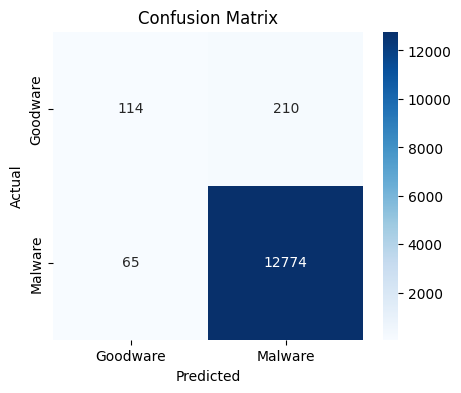

Test Accuracy: 97.91%


In [8]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Goodware", "Malware"]))


plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Goodware", "Malware"], yticklabels=["Goodware", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)*100
print(f"Test Accuracy: {accuracy:.2f}%")

How many columns after CountVectorizer? 253\
What does that number represent? The size of the vocabulary (i.e., number of distinct API calls across training samples)

What does each row represent? A vectorized version of a malware/goodware API sequence\
Can you still track the order of the processes (how they were called)? No, it's not possible anymore.

Do you have out-of-vocabulary in the test set? How many? 5

How does CountVectorizer handle OOV? It simply ignores words not present in the training vocabulary\
What classifier did you choose and why? Logistic Regression for a simple baseline with BoW

Final performance? Accuracy, Precision, Recall, F1 (da classification_report)

## Task 2: Feed Forward Neural Network

Now, obtain some stats on the number of processes called per sample.
- Do you have the same number of calls for each sample? Is the training distribution the
same as the test one? shorter than the testing ones.
- Let’s say that you really want to use a simple FeedForward neural network to solve the
problem. Can a Feedforward Neural Network handle a variable number of elements?
Why?
- Which technique do you adopt to bring everything to a fixed size during training? What
happens if at test time you have more processes to handle?
- Each process is actually a string: first solve the problem using sequential identifiers, then
try using learnable embeddings. Use a FeedForward network on both cases. Report how
you selected the hyper-parameters of your final model, and justify your choices. Can
you obtain the same results for the two alternatives (sequential identifiers and learnable
embeddings)?

Articulate (report results, whether one training was longer/more unstable than the other,
etc.)

In [9]:
train_df.head()
test_df.head()

,md5hash,api_call_sequence,is_malware,api_sequence_str
0,0765ce24323c6801e325d4266be073b9,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1,RegOpenKeyExA NtOpenKey NtQueryValueKey NtClos...
1,4480e321a0df8e0e8fa23a3c0a47c933,"[GetSystemMetrics, LdrLoadDll, LdrGetProcedure...",1,GetSystemMetrics LdrLoadDll LdrGetProcedureAdd...
2,f663674a8ddc469c383907b3930cd819,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1,NtClose NtOpenKey NtQueryValueKey NtClose NtOp...
3,49346a617852117dd162e8ae530664ef,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1,GetSystemTimeAsFileTime LdrLoadDll LdrGetProce...
4,a4b966898bfb48953109c9086163483b,"[GetSystemTimeAsFileTime, NtAllocateVirtualMem...",1,GetSystemTimeAsFileTime NtAllocateVirtualMemor...


Statistics about processes called per sample,for training set


,0
count,30713.000000
mean,75.039918
std,8.933816
min,60.000000
25%,67.000000
50%,75.000000
75%,83.000000
max,90.000000



Statistics about processes called per sample,for test set


,0
count,13163.000000
mean,85.111373
std,8.944844
min,70.000000
25%,77.000000
50%,85.000000
75%,93.000000
max,100.000000


<ipython-input-10-d956c9c9335a>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Not Malware (0)', 'Malware (1)'])


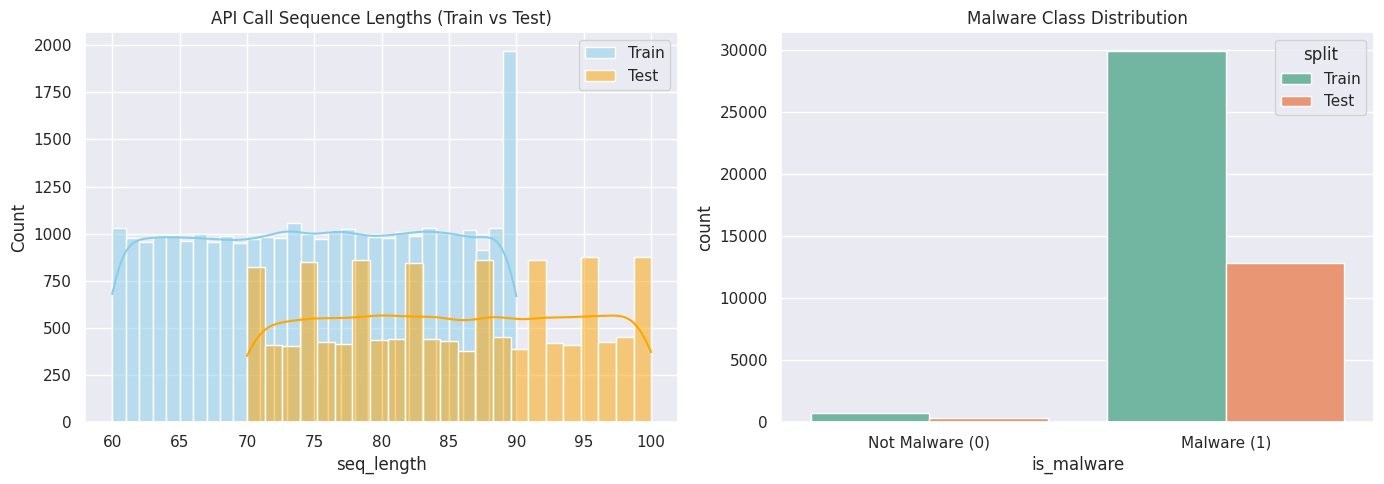

In [10]:
print("Statistics about processes called per sample,for training set")
train_cardinality = [len(x) for x in train_df['api_call_sequence']]
df_train_cardinality = pd.DataFrame(train_cardinality)
display(df_train_cardinality.describe())


print("\nStatistics about processes called per sample,for test set")
test_cardinality = [len(x) for x in test_df['api_call_sequence']]
df_test_cardinality = pd.DataFrame(test_cardinality)
display(df_test_cardinality.describe())

train_df['seq_length'] = train_df['api_call_sequence'].apply(len)
test_df['seq_length'] = test_df['api_call_sequence'].apply(len)

sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=train_df, x='seq_length', kde=True, color="skyblue", label='Train', ax=axs[0])
sns.histplot(data=test_df, x='seq_length', kde=True, color="orange", label='Test', ax=axs[0])
axs[0].set_title("API Call Sequence Lengths (Train vs Test)")
axs[0].legend()
train_df['split'] = 'Train'
test_df['split'] = 'Test'
combined = pd.concat([train_df[['is_malware', 'split']], test_df[['is_malware', 'split']]])

sns.countplot(data=combined, x='is_malware', hue='split', palette="Set2", ax=axs[1])
axs[1].set_title("Malware Class Distribution")
axs[1].set_xticklabels(['Not Malware (0)', 'Malware (1)'])

plt.tight_layout()
plt.show()

From the graph above, we observe that the cardinality of processes in the training set ranges from 60 to 90, while in the test set, it ranges from 70 to 100. This dataset cannot be directly managed by a FeedForward Neural Network (FFNN) due to its variable size. Therefore, preprocessing techniques and workarounds are necessary to adapt this architecture.

An FFNN expects a fixed number of input features because the input layer is predefined with a specific number of nodes. The network architecture (number of neurons in each layer, their connections, and weights) is fixed once the model is built.

To handle variable input sizes, you can use techniques to preprocess or adapt the data:
- Padding or Truncating: Pad shorter inputs with a default value (e.g., zeros) or truncate longer inputs to a fixed size. This ensures all inputs are of uniform length.
- Feature Aggregation: Apply aggregation techniques such as averaging or summing across variable-length data to create a fixed-size representation.

### Sequential Identifier

*lack of semantic information !!*

Preprocessing of training set
- padding
- split in training and validation set

In [11]:
unique_api_calls = set(api for seq in train_df['api_call_sequence'] for api in seq)
api_to_id = {api: index for index,api in enumerate(sorted(unique_api_calls))}

train_df["encoded_sequence"] = train_df["api_call_sequence"].apply(lambda seq: [api_to_id[api] for api in seq])

def pad_series(sequences,padding_value):
    max_length = max([len(x) for x in sequences])
    ret_value = np.full((len(sequences), max_length), padding_value, dtype=object)
    for idx, seq in enumerate(sequences):
        ret_value[idx, :len(seq)] = seq
    return ret_value

X_seq_id = pad_series(train_df['encoded_sequence'],0)
y_seq_id = y_train

# split training set to training and validate set
X_seq_id_train, X_seq_id_val, y_seq_id_train, y_seq_id_val = train_test_split(X_seq_id, y_seq_id, test_size=0.3, random_state=42)

# X_seq_id_train, y_seq_id_train
# X_seq_id_val, y_seq_id_val
# X_seq_id_test, y_seq_id_test

Processing the test set.
- managing out of vocabulary words
- padding
It has to be padded. The max length of the training set in 90, but on the test set it is 100. the only thing that we can do is to remove the extra values above 90.

In [12]:
# To manage OOV words, in test set they will have a key not present in the dictionary
UNKNOWN_API_ID = len(api_to_id)
test_df["encoded_sequence"] = test_df["api_call_sequence"].apply(lambda seq: [api_to_id.get(api,UNKNOWN_API_ID) for api in seq])
X_seq_id_test = pad_series(test_df['encoded_sequence'],0)
y_seq_id_test = y_test

X_seq_id_pad_test = X_seq_id_test[:,:90]

In [13]:
X_seq_id_train = np.array(X_seq_id_train, dtype=np.float32)
X_seq_id_val = np.array(X_seq_id_val, dtype=np.float32)
X_seq_id_pad_test = np.array(X_seq_id_pad_test, dtype=np.float32)


X_seq_id_train_tensor = torch.tensor(X_seq_id_train, dtype=torch.float32)
y_seq_id_train_tensor = torch.tensor(y_seq_id_train.tolist(), dtype=torch.long)
X_seq_id_val_tensor = torch.tensor(X_seq_id_val, dtype=torch.float32)
y_seq_id_val_tensor = torch.tensor(y_seq_id_val.tolist(), dtype=torch.long)

X_seq_id_test_tensor = torch.tensor(X_seq_id_pad_test, dtype=torch.float32)
y_seq_id_test_tensor = torch.tensor(y_seq_id_test.tolist(), dtype=torch.long)

In [14]:
input_size = X_seq_id_train_tensor.shape[1]
output_size = len(torch.unique(y_seq_id_train_tensor))

In [15]:
class FFNN1_Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(FFNN1_Model, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [16]:
# Training loop with early stopping
def training_loop_with_minibatch(model, train_loader, val_loader, device, optimizer, criterion, num_epoch, patience, debug):
    num_epochs = num_epoch
    patience = patience  # Early stopping patience
    best_model_state_dict = model.state_dict()
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))

        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        if (epoch + 1) % 10 == 0 and debug == True :
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            best_model_state_dict = model.state_dict()  # Save best model state
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if debug == True:
                print("Early stopping triggered.")
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    if debug == True:
        print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Load the best model state before returning
    model.load_state_dict(best_model_state_dict)

    # Plot training and validation losses
    if debug == True:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.yscale('log')
        plt.legend()
        plt.show()
    return model, train_losses, val_losses # Return the trained model and losses


In [17]:
def testing_model(model, dataloader, device, debug=False):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    if debug == True:
        print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy, all_labels, all_predictions

In [18]:
param_grid = {
    'learning_rate': [0.001,
                      #0.1,
                      #1,
                      ],
    'hidden_layers': [
        #[32, 64],
        #[64, 32, 16],
        [64, 128, 128, 64]
    ],
    'batch_size': [#16,
                   32,
                   #128
                   ],
    'optimizer': [
        #{'name': 'SGD+Momentum(0.3)', 'opt': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.3)},
        #{'name': 'SGD+Momentum(0.9)', 'opt': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)},
        {'name': 'AdamW', 'opt': lambda params, lr: optim.AdamW(params, lr=lr)}
    ]
}

In [19]:
grid = list(ParameterGrid(param_grid))
print(f"Grid has {len(grid)} dimension\n")
best_model = None
best_accuracy = 0
best_params = None
best_train_losses = None
best_val_losses = None
best_val_accuracy = 0
best_val_labels = []
best_val_preds = []

all_train_losses = []
all_val_losses = []
all_test_accuracies = []

g = torch.Generator()
g.manual_seed(42)

for idx, params in enumerate(grid):
    print(f"{idx}/{len(grid)} Testing parameters: "
          f"Hidden layers: {params['hidden_layers']}, "
          f"Batch size: {params['batch_size']}, "
          f"Optimizer: {params['optimizer']['name']}, "
          f"lr: {params['learning_rate']})",end = "")

    model = FFNN1_Model(input_size, output_size,params['hidden_layers'])
    criterion = nn.CrossEntropyLoss()
    optimizer = params['optimizer']['opt'](model.parameters(), lr=params['learning_rate'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_dataset = TensorDataset(X_seq_id_train_tensor, y_seq_id_train_tensor)
    val_dataset = TensorDataset(X_seq_id_val_tensor, y_seq_id_val_tensor)
    test_dataset = TensorDataset(X_seq_id_test_tensor, y_seq_id_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, generator=g)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    model, train_losses, val_losses = training_loop_with_minibatch(model, train_loader, val_loader, device, optimizer, criterion,num_epoch = 100, patience = 5, debug = False)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    val_accuracy, val_labels, val_preds = testing_model(model, val_loader, device)
    print(f"\tVal Accuracy: {val_accuracy:.2f}%")
    #test_accuracy, test_labels, test_preds = testing_model(model, test_loader, device, debug = False)
    #print(f"\tTest Accuracy: {test_accuracy:.2f}%")
    #print(f" - Test acc: {test_accuracy:.2f}%")
    #print(classification_report(test_labels, test_preds))

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_val_labels = val_labels
        best_val_preds = val_preds
        best_model = model
        best_params = params
        best_train_losses = train_losses
        best_val_losses = val_losses

Grid has 1 dimension

0/1 Testing parameters: Hidden layers: [64, 128, 128, 64], Batch size: 32, Optimizer: AdamW, lr: 0.001)	Val Accuracy: 97.86%


In [20]:
test_accuracy, test_labels, test_preds = testing_model(best_model, test_loader, device)


Best model parameters: Hidden layers: [64, 128, 128, 64], Batch size: 32, Optimizer: AdamW, lr: 0.001)
Test accuracy: 98.06%
              precision    recall  f1-score   support

           0       0.79      0.28      0.42       324
           1       0.98      1.00      0.99     12839

    accuracy                           0.98     13163
   macro avg       0.89      0.64      0.70     13163
weighted avg       0.98      0.98      0.98     13163



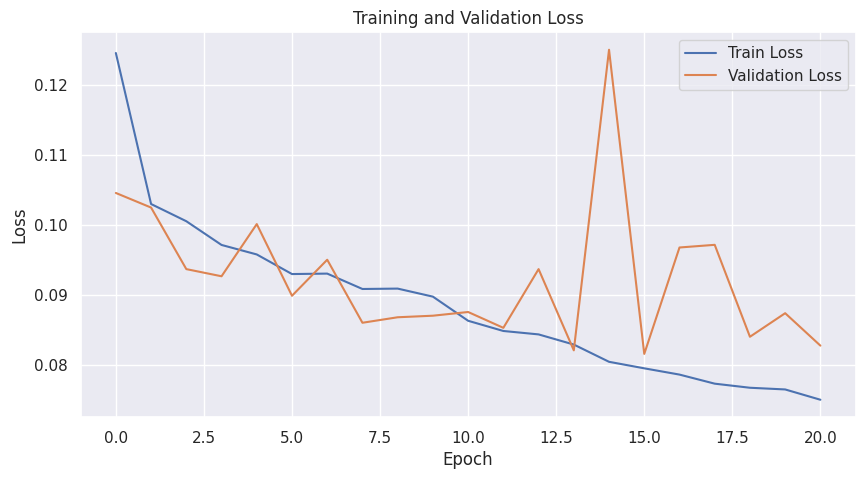

In [21]:
print(f"\nBest model parameters: Hidden layers: {best_params['hidden_layers']}, "
          f"Batch size: {best_params['batch_size']}, "
          f"Optimizer: {best_params['optimizer']['name']}, "
          f"lr: {best_params['learning_rate']})")
print(f"Test accuracy: {test_accuracy:.2f}%")
print(classification_report(test_labels, test_preds))

plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### learnable embeddings

## Task 3: Recursive Neural Network (RNN)
Next, use a Recursive Neural Network (RNN) to model your problem.
- Do you still have to pad your data? If yes, how?
- Do you have to truncate the testing sequences? Justify your answer with your under- standing of why it is/it is not the case.
- Is there any memory advantage on using an RNN wrt a FF when you process your dataset? Why?
- Start with a simple one-directional RNN. Is your network fast as the FF? If not, where do you think that time-overhead comes from?
- Train and tne three variations of networks:
  * Simple one-directional RNN
  * Bi-Directional RNN
  * LSTM (choose whether you want it one-directional or bi-directional)

  Can you see any differences during their training? Can you obtain the same

In [22]:
train_df['seq_length'] = train_df['api_call_sequence'].apply(len)
test_df['seq_length'] = test_df['api_call_sequence'].apply(len)
sequences = train_df['api_call_sequence'].tolist()
vocabulary = set()
for seq in sequences:
    vocabulary.update(seq)
vocabulary = sorted(list(vocabulary))  # Convert to sorted list for consistent indexing
# Create Mapping

vocab_size = len(api_to_id)
print(api_to_id)

{'CertOpenStore': 0, 'CertOpenSystemStoreW': 1, 'CoCreateInstance': 2, 'CoCreateInstanceEx': 3, 'CoGetClassObject': 4, 'CoInitializeEx': 5, 'CoInitializeSecurity': 6, 'CoUninitialize': 7, 'CopyFileA': 8, 'CopyFileExW': 9, 'CopyFileW': 10, 'CreateActCtxW': 11, 'CreateDirectoryW': 12, 'CreateJobObjectW': 13, 'CreateProcessInternalW': 14, 'CreateServiceA': 15, 'CreateServiceW': 16, 'CreateThread': 17, 'CreateToolhelp32Snapshot': 18, 'CryptAcquireContextA': 19, 'CryptAcquireContextW': 20, 'CryptCreateHash': 21, 'CryptDecodeObjectEx': 22, 'CryptDecrypt': 23, 'CryptEncrypt': 24, 'CryptExportKey': 25, 'CryptGenKey': 26, 'CryptHashData': 27, 'CryptProtectData': 28, 'CryptProtectMemory': 29, 'DeleteFileW': 30, 'DeleteUrlCacheEntryA': 31, 'DeleteUrlCacheEntryW': 32, 'DeviceIoControl': 33, 'DnsQuery_A': 34, 'DrawTextExA': 35, 'DrawTextExW': 36, 'EnumServicesStatusA': 37, 'EnumWindows': 38, 'FindFirstFileExA': 39, 'FindFirstFileExW': 40, 'FindResourceA': 41, 'FindResourceExA': 42, 'FindResourceExW

In [23]:
api_to_index = {api: idx + 2 for idx, api in enumerate(sorted(unique_api_calls))}
api_to_index['<PAD>'] = 0
api_to_index['<UNK>'] = 1

vocab_size = len(api_to_index)
index_to_api = {v: k for k, v in api_to_index.items()}
print(index_to_api)
def encode_sequence(seq):
    return torch.tensor([api_to_index.get(api, api_to_index['<UNK>']) for api in seq], dtype=torch.long)


{2: 'CertOpenStore', 3: 'CertOpenSystemStoreW', 4: 'CoCreateInstance', 5: 'CoCreateInstanceEx', 6: 'CoGetClassObject', 7: 'CoInitializeEx', 8: 'CoInitializeSecurity', 9: 'CoUninitialize', 10: 'CopyFileA', 11: 'CopyFileExW', 12: 'CopyFileW', 13: 'CreateActCtxW', 14: 'CreateDirectoryW', 15: 'CreateJobObjectW', 16: 'CreateProcessInternalW', 17: 'CreateServiceA', 18: 'CreateServiceW', 19: 'CreateThread', 20: 'CreateToolhelp32Snapshot', 21: 'CryptAcquireContextA', 22: 'CryptAcquireContextW', 23: 'CryptCreateHash', 24: 'CryptDecodeObjectEx', 25: 'CryptDecrypt', 26: 'CryptEncrypt', 27: 'CryptExportKey', 28: 'CryptGenKey', 29: 'CryptHashData', 30: 'CryptProtectData', 31: 'CryptProtectMemory', 32: 'DeleteFileW', 33: 'DeleteUrlCacheEntryA', 34: 'DeleteUrlCacheEntryW', 35: 'DeviceIoControl', 36: 'DnsQuery_A', 37: 'DrawTextExA', 38: 'DrawTextExW', 39: 'EnumServicesStatusA', 40: 'EnumWindows', 41: 'FindFirstFileExA', 42: 'FindFirstFileExW', 43: 'FindResourceA', 44: 'FindResourceExA', 45: 'FindResou

In [24]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['is_malware'])
encoded_train = [encode_sequence(seq) for seq in train_df['api_call_sequence']]
encoded_test = [encode_sequence(seq) for seq in test_df['api_call_sequence']]

padded_train = pad_sequence(encoded_train, batch_first=True, padding_value=api_to_index['<PAD>'])
padded_test = pad_sequence(encoded_test, batch_first=True, padding_value=api_to_index['<PAD>'])

train_labels = torch.tensor(train_df['is_malware'].values, dtype=torch.float32)
test_labels = torch.tensor(test_df['is_malware'].values, dtype=torch.float32)
val_sequences = [encode_sequence(seq) for seq in val_df['api_call_sequence']]
val_labels = torch.tensor(val_df['is_malware'].values, dtype=torch.float32)

In [25]:
class MalwareDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        length = len(sequence)
        return sequence, label, length

In [26]:
def collate_fn(batch):
    sequences, labels, lengths = zip(*batch)
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=api_to_index['<PAD>'])
    return padded_seqs, torch.tensor(lengths), torch.tensor(labels)

In [27]:
train_ds = MalwareDataset(encoded_train, train_labels)
test_ds = MalwareDataset(encoded_test, test_labels)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn)
val_ds = MalwareDataset(val_sequences, val_labels)
val_dl = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn)

In [28]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64, padding_idx=0):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=api_to_index['<PAD>'])
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        x_embed = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(x_embed, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, h_n = self.rnn(packed)
        out = self.fc(h_n.squeeze(0))
        return self.sigmoid(out).squeeze()

In [29]:
class BiRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64, num_layers=1, padding_idx=0):
        super(BiRNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)

        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2, 1)  # 2 for BiRNN (forward + backward)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        """
        Forward pass.

        Args:
            x: Tensor of token indices [batch_size, seq_len]
            lengths: Actual sequence lengths [batch_size]
        """
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        # hidden shape: [2 (directions), batch_size, hidden_dim]

        h_forward = hidden[-2, :, :]
        h_backward = hidden[-1, :, :]
        h_cat = torch.cat((h_forward, h_backward), dim=1)  # [batch_size, hidden_dim * 2]

        out = self.fc(h_cat)  # [batch_size, 1]
        return self.sigmoid(out).squeeze()

In [30]:
class LSTMClassifier(nn.Module):
    """
    One-directional LSTM classifier for API call sequences.
    Uses an Embedding layer + LSTM + FC for binary classification.
    """
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64, num_layers=1, padding_idx=0):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)

        final_hidden = h_n[-1]
        out = self.fc(final_hidden)
        return self.sigmoid(out).squeeze()

In [31]:
def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion, patience=10):
    start_time = time.time()
    train_losses = []
    val_losses = []
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x, lengths)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * x.size(0)
        train_losses.append(total_train_loss / len(train_dataset))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, lengths, y in val_loader:
                x, lengths, y = x.to(device), lengths.to(device), y.to(device)
                outputs = model(x, lengths)
                loss = criterion(outputs, y)
                total_val_loss += loss.item() * x.size(0)
        val_loss = total_val_loss / len(val_dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

def test_model(model, dataloader, device):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths = x.to(device), lengths.to(device)
            preds = model(x, lengths) >= 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [32]:
if torch.cuda.is_available():
    num_epochs = 200
else:
    num_epochs = 15
print(f"Number of epochs: {num_epochs}")

Number of epochs: 200


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
RNNmodel = RNNClassifier(vocab_size=vocab_size, padding_idx=api_to_index['<PAD>'])

In [35]:
optimizer = torch.optim.Adam(RNNmodel.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch 1/200, Train Loss: 0.1201, Val Loss: 0.1097
Epoch 2/200, Train Loss: 0.1039, Val Loss: 0.1023
Epoch 3/200, Train Loss: 0.0944, Val Loss: 0.0986
Epoch 4/200, Train Loss: 0.0930, Val Loss: 0.0894
Epoch 5/200, Train Loss: 0.0880, Val Loss: 0.0921
Epoch 6/200, Train Loss: 0.0832, Val Loss: 0.0889
Epoch 7/200, Train Loss: 0.0795, Val Loss: 0.1062
Epoch 8/200, Train Loss: 0.0759, Val Loss: 0.0856
Epoch 9/200, Train Loss: 0.0770, Val Loss: 0.0913
Epoch 10/200, Train Loss: 0.0710, Val Loss: 0.0829
Epoch 11/200, Train Loss: 0.0677, Val Loss: 0.0833
Epoch 12/200, Train Loss: 0.0628, Val Loss: 0.0743
Epoch 13/200, Train Loss: 0.0638, Val Loss: 0.0825
Epoch 14/200, Train Loss: 0.0597, Val Loss: 0.0762
Epoch 15/200, Train Loss: 0.0642, Val Loss: 0.0813
Epoch 16/200, Train Loss: 0.0597, Val Loss: 0.0805
Epoch 17/200, Train Loss: 0.0562, Val Loss: 0.0778
Epoch 18/200, Train Loss: 0.0531, Val Loss: 0.0794
Epoch 19/200, Train Loss: 0.0564, Val Loss: 0.0894
Epoch 20/200, Train Loss: 0.0560, Val Lo

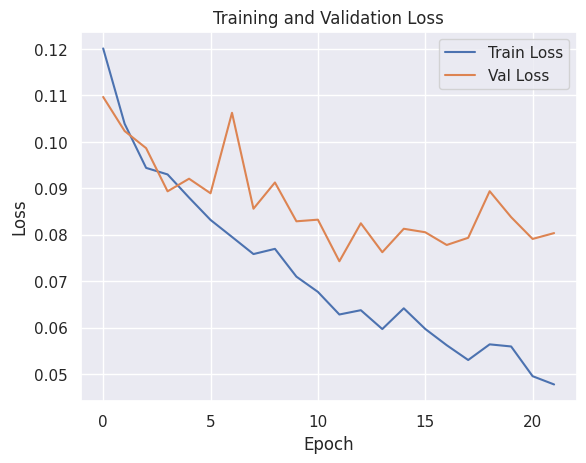

Test Accuracy: 98.05%


In [36]:
training_loop(RNNmodel, train_dl, test_dl, train_ds, test_ds, device, optimizer, num_epochs=num_epochs, criterion=criterion)
accuracy = test_model(RNNmodel, test_dl, device)
print(f"Test Accuracy: {accuracy:.2%}")

In [37]:
BiRNNmodel = BiRNNClassifier(vocab_size=vocab_size, padding_idx=api_to_index['<PAD>'])

In [38]:
optimizer = torch.optim.Adam(BiRNNmodel.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch 1/200, Train Loss: 0.0922, Val Loss: 0.0802
Epoch 2/200, Train Loss: 0.0746, Val Loss: 0.0715
Epoch 3/200, Train Loss: 0.0676, Val Loss: 0.0666
Epoch 4/200, Train Loss: 0.0609, Val Loss: 0.0612
Epoch 5/200, Train Loss: 0.0560, Val Loss: 0.0575
Epoch 6/200, Train Loss: 0.0520, Val Loss: 0.0595
Epoch 7/200, Train Loss: 0.0504, Val Loss: 0.0694
Epoch 8/200, Train Loss: 0.0508, Val Loss: 0.0577
Epoch 9/200, Train Loss: 0.0462, Val Loss: 0.0593
Epoch 10/200, Train Loss: 0.0483, Val Loss: 0.0579
Epoch 11/200, Train Loss: 0.0434, Val Loss: 0.0582
Epoch 12/200, Train Loss: 0.0411, Val Loss: 0.0585
Epoch 13/200, Train Loss: 0.0424, Val Loss: 0.0593
Epoch 14/200, Train Loss: 0.0386, Val Loss: 0.0550
Epoch 15/200, Train Loss: 0.0389, Val Loss: 0.0556
Epoch 16/200, Train Loss: 0.0356, Val Loss: 0.0564
Epoch 17/200, Train Loss: 0.0352, Val Loss: 0.0620
Epoch 18/200, Train Loss: 0.0367, Val Loss: 0.0635
Epoch 19/200, Train Loss: 0.0341, Val Loss: 0.0571
Epoch 20/200, Train Loss: 0.0330, Val Lo

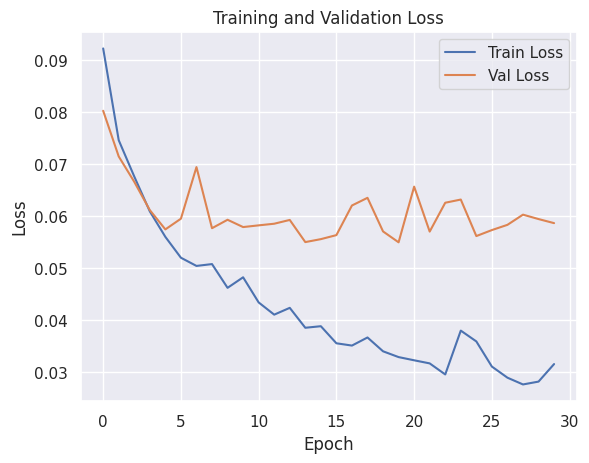

Test Accuracy: 98.64%


In [39]:
training_loop(BiRNNmodel, train_dl, test_dl, train_ds, test_ds, device, optimizer, num_epochs=num_epochs, criterion=criterion)
accuracy = test_model(BiRNNmodel, test_dl, device)
print(f"Test Accuracy: {accuracy:.2%}")

In [40]:
LSTMmodel = LSTMClassifier(vocab_size=vocab_size, padding_idx=api_to_index['<PAD>'])

In [41]:
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch 1/200, Train Loss: 0.1170, Val Loss: 0.1013
Epoch 2/200, Train Loss: 0.0878, Val Loss: 0.0782
Epoch 3/200, Train Loss: 0.0756, Val Loss: 0.0699
Epoch 4/200, Train Loss: 0.0653, Val Loss: 0.0636
Epoch 5/200, Train Loss: 0.0590, Val Loss: 0.0618
Epoch 6/200, Train Loss: 0.0538, Val Loss: 0.0564
Epoch 7/200, Train Loss: 0.0500, Val Loss: 0.0568
Epoch 8/200, Train Loss: 0.0457, Val Loss: 0.0539
Epoch 9/200, Train Loss: 0.0435, Val Loss: 0.0525
Epoch 10/200, Train Loss: 0.0405, Val Loss: 0.0577
Epoch 11/200, Train Loss: 0.0391, Val Loss: 0.0556
Epoch 12/200, Train Loss: 0.0344, Val Loss: 0.0495
Epoch 13/200, Train Loss: 0.0325, Val Loss: 0.0496
Epoch 14/200, Train Loss: 0.0300, Val Loss: 0.0503
Epoch 15/200, Train Loss: 0.0306, Val Loss: 0.0505
Epoch 16/200, Train Loss: 0.0264, Val Loss: 0.0452
Epoch 17/200, Train Loss: 0.0247, Val Loss: 0.0501
Epoch 18/200, Train Loss: 0.0275, Val Loss: 0.0500
Epoch 19/200, Train Loss: 0.0251, Val Loss: 0.0591
Epoch 20/200, Train Loss: 0.0230, Val Lo

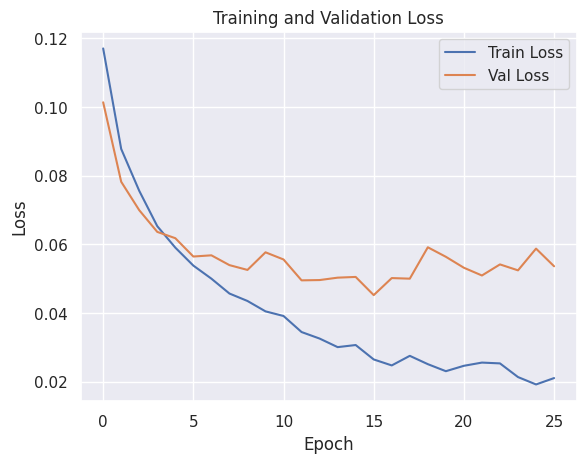

Test Accuracy: 98.81%


In [42]:
training_loop(LSTMmodel, train_dl, test_dl, train_ds, test_ds, device, optimizer, num_epochs=num_epochs, criterion=criterion)
accuracy = test_model(LSTMmodel, test_dl, device)
print(f"Test Accuracy: {accuracy:.2%}")

In [43]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def testing_model(model, dataloader, device):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths = x.to(device), lengths.to(device)
            outputs = model(x, lengths)
            preds = (outputs >= 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    plot_confusion_matrix(all_labels, all_preds, ["Benign", "Malware"])
    return acc


 Evaluating: MonoRNNmodel


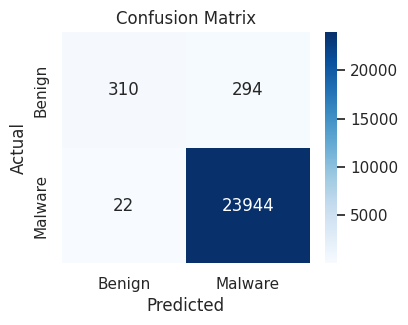

 Train Accuracy:     98.71%


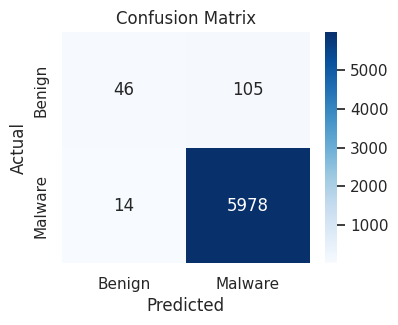

 Validation Accuracy: 98.06%


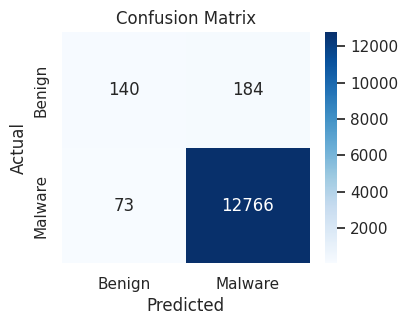

 Test Accuracy:      98.05%

 Evaluating: BiRNNmodel


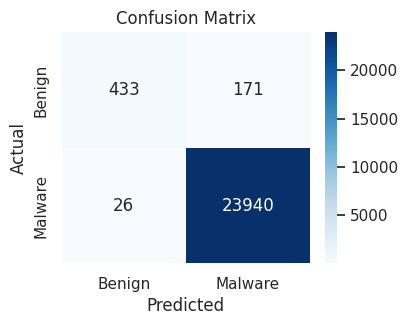

 Train Accuracy:     99.20%


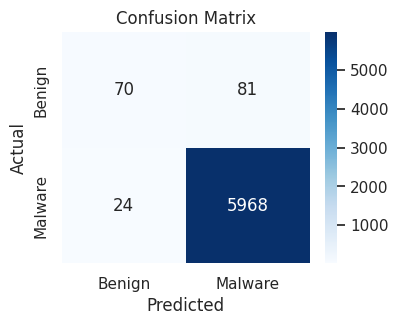

 Validation Accuracy: 98.29%


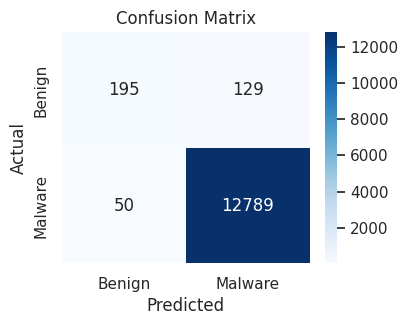

 Test Accuracy:      98.64%

 Evaluating: LSTMmodel


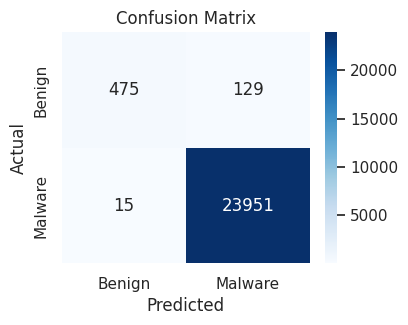

 Train Accuracy:     99.41%


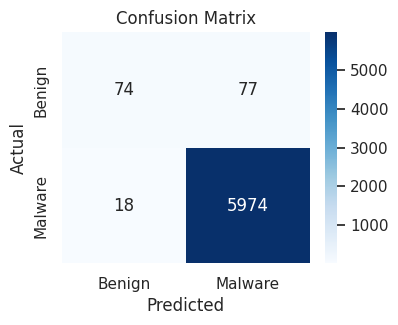

 Validation Accuracy: 98.45%


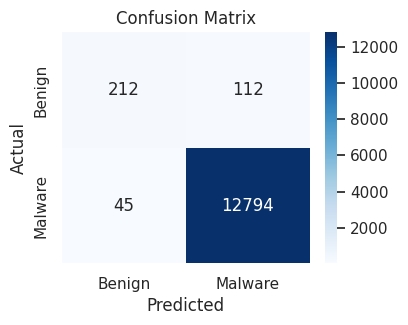

 Test Accuracy:      98.81%


In [44]:
model_names = ["MonoRNNmodel", "BiRNNmodel", "LSTMmodel"]
models = [RNNmodel, BiRNNmodel, LSTMmodel]

for i in range(len(model_names)):
    model = models[i]
    print(f"\n Evaluating: {model_names[i]}")

    train_acc = testing_model(model, train_dl, device)
    print(f" Train Accuracy:     {train_acc:.2f}%")

    val_acc = testing_model(model, val_dl, device)
    print(f" Validation Accuracy: {val_acc:.2f}%")

    test_acc = testing_model(model, test_dl, device)
    print(f" Test Accuracy:      {test_acc:.2f}%")

## Task 4: Graph Neural Network (GNN)
Finally, use a Graph Neural Network (GNN) to model your problem. Consider each sequence
of API call as a graph.
- Do you still have to pad your data? If yes, how?
- Do you have to truncate the testing sequences? Justify your answer with your under- standing of why it is/it is not the case.
- What is the advantage of modelling your problem with a GNN with respect to FFNN and RNN? What do you lose?
- Start creating a first simple GCN and train/test it on CPU first and GPU next. How long does it take for training and testing in each configuration? How does it differ with respect to previous architectures? Can you guess why
- Finally train and tune variations of GNN considering different message and aggregation functions and architectures:
    * Simple GCN
    * GraphSAGE
    * and GAT
    Can you see any differences during their training? Can you obtain the same

In [ ]:
train_df['seq_length'] = train_df['api_call_sequence'].apply(len)
test_df['seq_length'] = test_df['api_call_sequence'].apply(len)
sequences = train_df['api_call_sequence'].tolist()

# Step 2: Build vocabulary and fit encoder
api_calls = sorted(set(api for seq in sequences for api in seq))
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(np.array(api_calls).reshape(-1, 1))

# Step 3: Sequence to Graph
def sequence_to_graph(sequence):
    node_features = encoder.transform(np.array(sequence).reshape(-1, 1))
    edge_index = []
    for i in range(len(sequence) - 1):
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])
    edge_index = np.array(edge_index).T
    return edge_index, node_features

# Step 4: Graph data preparation
def prepare_graph_data(df):
    adj_list = []
    feat_list = []
    label_list = []
    for _, row in df.iterrows():
        adj, feat = sequence_to_graph(row['api_call_sequence'])
        adj_list.append(adj)
        feat_list.append(feat)
        label_list.append(row['is_malware'])
    return adj_list, feat_list, label_list

train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)

# Step 5: Apply to train/val/test
tr_adj, tr_feat, tr_class = prepare_graph_data(train_data)
val_adj, val_feat, val_class = prepare_graph_data(val_data)
te_adj, te_feat, te_class = prepare_graph_data(test_df)

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, features, labels, transform=None):
        """
        Initialize dataset by pre-processing all graphs into PyG `Data` format.

        Args:
            adj_matrices (list of np.array): List of adjacency matrices.
            features (list of np.array): List of node feature matrices.
            labels (list of int): List of graph labels.
            transform (callable, optional): Optional transform to apply to data.
        """
        super().__init__(transform)
        self.graphs = []  # Store processed graphs

        for i in range(len(adj_matrices)):
            # Convert adjacency matrix to edge index
            edge_index = torch.tensor(np.array(adj_matrices[i].nonzero()), dtype=torch.long)

            # Convert node features
            x = torch.tensor(features[i], dtype=torch.float)

            # Ensure `y` is a single integer label
            #labels[i].nonzero()[0] to encode the label from a one-hot-encoding rappresentation
            #into a numerical version
            y = torch.tensor(labels[i], dtype=torch.long).unsqueeze(0)

            # Create Data object and store it
            self.graphs.append(Data(x=x, edge_index=edge_index, y=y))

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]  # Return pre-processed graph

In [ ]:
train_adj, train_feat, train_labels = tr_adj, tr_feat, tr_class
val_adj, val_feat, val_labels = val_adj, val_feat, val_class
test_adj, test_feat, test_labels = te_adj, te_feat, te_class

# Create datasets
train_dataset = GraphDataset(train_adj, train_feat, train_labels)
val_dataset = GraphDataset(val_adj, val_feat, val_labels)
test_dataset = GraphDataset(test_adj, test_feat, test_labels)

print(f"Train dataset length: {len(train_dataset)}, Validation dataset length: {len(val_dataset)}, Test dataset length: {len(test_dataset)}")

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

In [ ]:
batch = next(iter(train_loader))
batch

In [ ]:
batch = next(iter(train_loader))
num_graphs = batch.y.size(0)

for i in range(num_graphs):
    print("Graph", i)
    node_mask = batch.batch == i
    node_indices = node_mask.nonzero(as_tuple=True)[0]
    print("Number of nodes:", node_mask.sum())

    x_i = batch.x[node_indices]

    # Filter edges where both source and destination are in this graph
    src_mask = torch.isin(batch.edge_index[0], node_indices)
    dst_mask = torch.isin(batch.edge_index[1], node_indices)
    edge_mask = src_mask & dst_mask
    print("Number of edges:", edge_mask.sum())

    edge_index_i = batch.edge_index[:, edge_mask]

    # Re-index nodes to start from 0
    mapping = {old.item(): new for new, old in enumerate(node_indices)}
    edge_index_i = torch.tensor([[mapping[n.item()] for n in edge_index_i[0]],
                                 [mapping[n.item()] for n in edge_index_i[1]]], dtype=torch.long)

    print("Label", batch.y[i])

In [ ]:
smallest = 0
size_small = 170
for i in range(len(train_dataset)):
    if(size_small > len(train_dataset[i].x)):
        size_small = len(train_dataset[i].x)
        smallest = i
print("smallest graph id",smallest,"size",size_small,"nodes")

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx

In [ ]:
def plot_graph(data):
    """Visualize a PyTorch Geometric graph with node and edge features."""
    G = to_networkx(data, to_undirected=True)

    # Get node positions for consistent layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph structure
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
            node_size=800, font_size=7)

    # Format node features
    node_labels = {i: f"{[round(f, 2) for f in data.x[i].tolist()]}" for i in range(data.x.shape[0])}

    # Display node features slightly above nodes
    offset = 0.05  # Adjust for better visibility
    pos_shifted = {k: (v[0], v[1] + offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, pos_shifted, labels=node_labels, font_size=8, font_color="darkred")

    # Add edge features if available
    if hasattr(data, "edge_attr") and data.edge_attr is not None:
        edge_labels = {(u, v): f"{[round(e, 2) for e in data.edge_attr[idx].tolist()]}"
                       for idx, (u, v) in enumerate(data.edge_index.T.tolist())}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="darkblue")

    plt.title(f"Graph Example - Label: {data.y.item()}")
    plt.show()

# Plot the smallest graph
plot_graph(train_dataset[12])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train loader: {len(train_loader)}, Validation loader: {len(val_loader)}, Test loader: {len(test_loader)}")

In [ ]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Must match batch size
        out = self.fc(x)
        return out

#GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)# Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x

#GAT Model (Graph Attention Network)
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch) # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name, model_name):
    """
    Creates and displays a confusion matrix to evaluate classification performance.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names for axis labels
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix +" +dataset_name+ " "+ model_name)
    plt.show()

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.

    Returns:
        None: The function plots the training and validation loss over the epochs.
    """


    # Record the start time
    start_time = time.time()


    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch)  # Forward pass
            loss = criterion(outputs, batch.y.squeeze())  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                batch = batch.to(device)  # Move batch to GPU
                val_outputs = model(batch)  # Forward pass
                loss = criterion(val_outputs, batch.y.squeeze())  # Compute validation loss. .squeeze() is used to reduce from 2D to 1D vector
                val_loss += loss.item() * batch.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return

def testing_model(model, dataloader, device, dataset_name, model_name):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch in dataloader:
            batch = batch.to(device)  # Move batch to GPU
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(batch.y.squeeze().cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Define class names
    class_names = [f"Class {cls}" for cls in np.unique(all_labels)]

    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_predictions, class_names, dataset_name, model_name)

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GCNmodel = GCN(input_dim=train_feat[0].shape[1], hidden_dim=64, output_dim=3)
GCNmodel.to(device)
optimizer = optim.Adam(GCNmodel.parameters(), lr=0.001)
training_loop(GCNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GraphSAGEmodel = GraphSAGE(input_dim=train_feat[0].shape[1], hidden_dim=64, output_dim=3)
GraphSAGEmodel.to(device)
optimizer = optim.Adam(GraphSAGEmodel.parameters(), lr=0.001)
training_loop(GraphSAGEmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GATmodel = GAT(input_dim=train_feat[0].shape[1], hidden_dim=64, output_dim=3)
GATmodel.to(device)
optimizer = optim.Adam(GATmodel.parameters(), lr=0.001)
training_loop(GATmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)